In [2]:
#pip install regionmask

In [3]:
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gp
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.colors as mcolors
import regionmask
from xmip.regionmask import merged_mask
import pandas as pd
import gcsfs
import cmocean

fs = gcsfs.GCSFileSystem()
%run _Val_Mapping.ipynb

# Make regional masks

In [5]:
#from this webpage: https://www.marineregions.org

bering = gp.read_file('/home/jovyan/mCDR/shapefiles/bering.zip')
gulf = gp.read_file('/home/jovyan/mCDR/shapefiles/gulf.zip')
caribbean = gp.read_file('/home/jovyan/mCDR/shapefiles/caribbean.zip')

lon = np.arange(-180, 180,.1)
lat = np.arange(-90, 90,.1)

mask_bering = regionmask.mask_geopandas(bering, lon, lat)
mask_gulf = regionmask.mask_geopandas(gulf, lon, lat)
mask_caribbean = regionmask.mask_geopandas(caribbean, lon, lat)

## Load HR-CESM-testbed truth and reconstructions

In [6]:
# Bring in datasets
truth = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/processed/pco2_components_202002-202201.zarr', engine='zarr').pCO2SURF 
unseen_global_2000_2022 = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/0022_global/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen
unseen_global_2020_2022 = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/2022_global/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen
unseen_global_2020_2022_float = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/2022_global_float/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen

# Assign_dimension coordinates
truth = truth.assign_coords(status='truth')
unseen_global_2000_2022 = unseen_global_2000_2022.assign_coords(status='reconstruction')
unseen_global_2020_2022 = unseen_global_2020_2022.assign_coords(status='reconstruction')
unseen_global_2020_2022_float = unseen_global_2020_2022_float.assign_coords(status='reconstruction')

# Make sure they have the same time coordinates
CESM_ds_global_2000_2022 = xr.concat([truth, unseen_global_2000_2022], dim='status')
CESM_ds_global_2020_2022 = xr.concat([truth, unseen_global_2020_2022], dim='status')
CESM_ds_global_2020_2022_float = xr.concat([truth, unseen_global_2020_2022_float], dim='status')

## Calculate bias and RMSE

In [7]:
##BIAS##
bias_global_2000_2022 = CESM_ds_global_2000_2022.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status'])
bias_global_2020_2022 = CESM_ds_global_2020_2022.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status'])
bias_global_2020_2022_float = CESM_ds_global_2020_2022_float.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status'])

##RMSE##
rmse_global_2000_2022 = np.sqrt(((CESM_ds_global_2000_2022.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status']))
rmse_global_2020_2022 = np.sqrt(((CESM_ds_global_2020_2022.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status']))
rmse_global_2020_2022_float = np.sqrt(((CESM_ds_global_2020_2022_float.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status']))

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_8063/2090988830.py:50: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('Mean 2020-2021 RMSE ($\mu atm$)', fontsize=12);


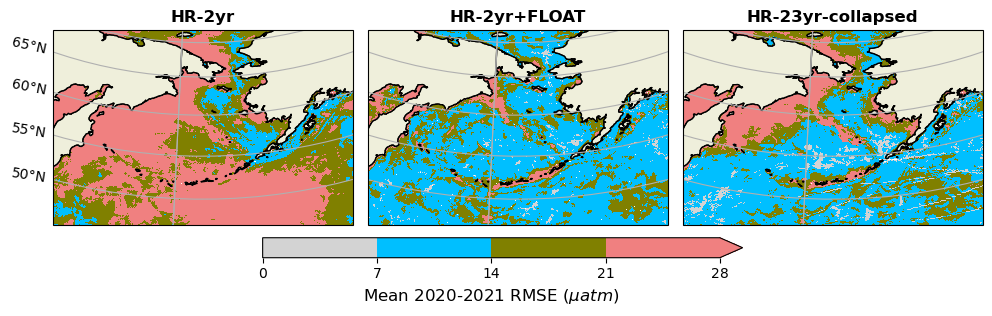

In [9]:
# Define extent
#extent = [-100, -60, 0, 30]  # Gulf of Mexico and Caribbean Sea
#extent = [-180, -60, 0, 90] # Whole region

extent = [-200, -150, 45, 70] # Bering
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Define datasets
datasets = [rmse_global_2020_2022, rmse_global_2020_2022_float, rmse_global_2000_2022]
titles = ["HR-2yr", "HR-2yr+FLOAT", "HR-23yr-collapsed"]

# Define custom colormap
colors = ['lightgray', 'deepskyblue', 'olive', 'lightcoral']  # Four distinct colors
cmap = mcolors.ListedColormap(colors)
bounds = [0, 7, 14, 21, 28]  # Define bin edges
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), 
                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
# Adjust subplot spacing
plt.subplots_adjust(wspace=0.05, hspace=0)  # Reduce gaps between panels

# Loop through datasets and axes
for i, (ax, data, title) in enumerate(zip(axes, datasets, titles)):
    ax.set_extent(extent)
    ax.coastlines(resolution='50m')
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')

    # Enable gridlines
    gl = ax.gridlines(draw_labels=True)
    
    # Only show y-axis labels on the left panel
    gl.left_labels = (i == 0)  # Labels only on the leftmost panel
    gl.right_labels = False  # No right-side labels

    # Hide x-axis labels
    gl.top_labels = False  
    gl.bottom_labels = False

    # Plot each dataset
    img = data.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=28, cmap=cmap, norm=norm, add_colorbar=False)
    
    ax.set_title(title, fontsize=12, fontweight='bold')

# Add a shared colorbar
cbar_ax = fig.add_axes([0.3, 0.17, 0.4, 0.05])  # x, vertical position, width, height
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal', ticks=bounds,extend='max')
cbar.set_label('Mean 2020-2021 RMSE ($\mu atm$)', fontsize=12);

#plt.savefig("/home/jovyan/rmse_bering.jpg",dpi=300, bbox_inches="tight");

<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7548/765953557.py:43: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label("Mean 2020-2021 RMSE ($\mu atm$)", fontsize=12);


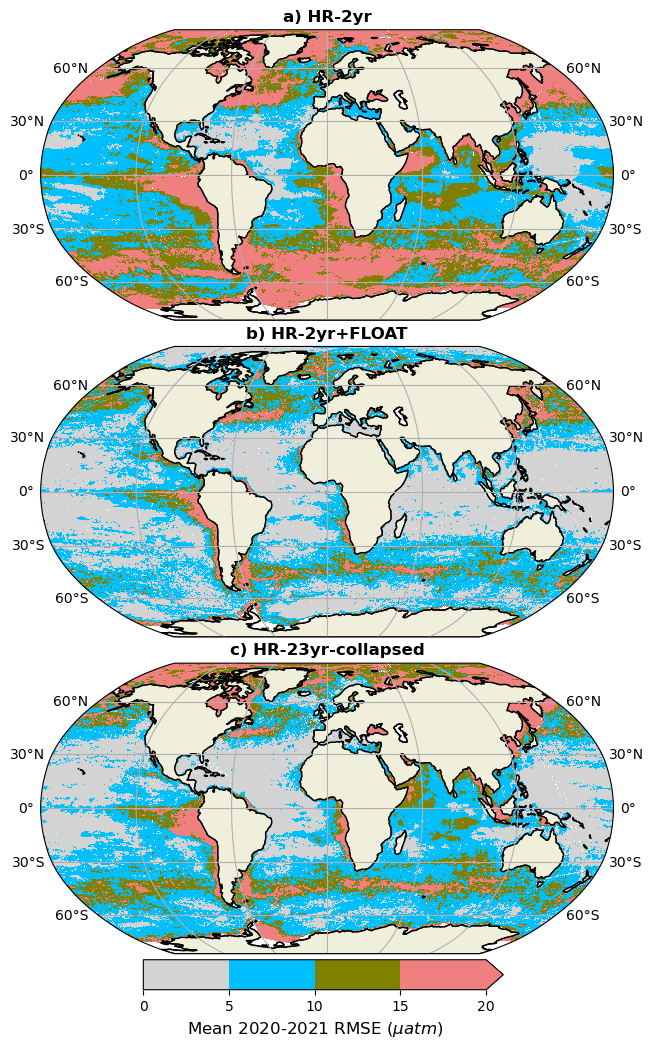

In [10]:
# Define projection (Robinson is good for global views)
projection = ccrs.Robinson()
# Create figure and axes for three panels
#fig, axes = plt.subplots(3, 1, figsize=(15, 6), subplot_kw={'projection': projection})
fig, axes = plt.subplots(3, 1, figsize=(15, 12), subplot_kw={'projection': projection})

# Reduce space between subplots
#plt.subplots_adjust(wspace=0.01)  # Reduce horizontal spacing
plt.subplots_adjust(hspace=0.09)  # Reduce vertical spacing

# Define custom colormap
colors = ['lightgray', 'deepskyblue', 'olive', 'lightcoral']
cmap = mcolors.ListedColormap(colors)
bounds = [0, 5, 10, 15, 20]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Loop through datasets
datasets = [rmse_global_2020_2022, rmse_global_2020_2022_float, rmse_global_2000_2022]
titles = ["a) HR-2yr", "b) HR-2yr+FLOAT", "c) HR-23yr-collapsed"]

for i, (ax, data, title) in enumerate(zip(axes, datasets, titles)):
    ax.set_global()  # Show entire world
    ax.coastlines(resolution='110m')  # Use a lower resolution for global maps
    ax.add_feature(cfeature.LAND, edgecolor='black')

    # Enable gridlines but only show y-axis labels on the leftmost panel
    gl = ax.gridlines(draw_labels=True)
    #gl.left_labels = (i == 0)  # Only show left y-axis labels on the first panel
    gl.left_labels = True  # Only show left y-axis labels on the first panel
    gl.right_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

    # Plot data
    img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
    ax.set_title(title, fontsize=12, fontweight="bold")

# Add a colorbar
#cbar_ax = fig.add_axes([0.3, 0.27, 0.4, 0.04]) # for horizontal
cbar_ax = fig.add_axes([0.39, 0.08, 0.24, 0.025])  # x, vertical position, width, height
cbar = fig.colorbar(img, cax=cbar_ax, orientation="horizontal", ticks=bounds,extend='max')
#cbar.ax.set_xticklabels(['0', '5', '10', '15', '≥20'])
cbar.set_label("Mean 2020-2021 RMSE ($\mu atm$)", fontsize=12);
plt.savefig("/home/jovyan/rmse.jpg",dpi=300, bbox_inches="tight");

### Apply masks

In [8]:
# rename variables to match recon
mask_bering  = mask_bering.to_dataset().rename({"lon":"longitude", "lat": "latitude"})
mask_gulf  = mask_gulf.to_dataset().rename({"lon":"longitude", "lat": "latitude"})
mask_caribbean = mask_caribbean.to_dataset().rename({"lon":"longitude", "lat": "latitude"})

In [9]:
### Bering ###
bias_masked_bering_global_2020_2022 = bias_global_2020_2022.where(mask_bering.mask.values==0.)
bias_masked_bering_global_2020_2022_float = bias_global_2020_2022_float.where(mask_bering.mask.values==0.)
rmse_masked_bering_global_2020_2022 = rmse_global_2020_2022.where(mask_bering.mask.values==0.)
rmse_masked_bering_global_2020_2022_float = rmse_global_2020_2022_float.where(mask_bering.mask.values==0.)

### Gulf of Mexico ###
bias_masked_gulf_global_2020_2022 = bias_global_2020_2022.where(mask_gulf.mask.values==0.)
bias_masked_gulf_global_2020_2022_float = bias_global_2020_2022_float.where(mask_gulf.mask.values==0.)
rmse_masked_gulf_global_2020_2022 = rmse_global_2020_2022.where(mask_gulf.mask.values==0.)
rmse_masked_gulf_global_2020_2022_float = rmse_global_2020_2022_float.where(mask_gulf.mask.values==0.)

### Caribbean Sea ###
bias_masked_caribbean_global_2020_2022 = bias_global_2020_2022.where(mask_caribbean.mask.values==0.)
bias_masked_caribbean_global_2020_2022_float = bias_global_2020_2022_float.where(mask_caribbean.mask.values==0.)
rmse_masked_caribbean_global_2020_2022 = rmse_global_2020_2022.where(mask_caribbean.mask.values==0.)
rmse_masked_caribbean_global_2020_2022_float = rmse_global_2020_2022_float.where(mask_caribbean.mask.values==0.)

## Timeseries

### Need to add time dimension for the masks to make timeseries

In [10]:
# Assume your original data is a 2D array of shape (1800, 3600)
data_array = mask_bering.mask

# Define latitude and longitude coordinates
latitudes = np.linspace(-90, 90, 1800)
longitudes = np.linspace(-180, 180, 3600)

# Create a DataArray from the data
data = xr.DataArray(data_array, dims=['latitude', 'longitude'], 
                    coords={'latitude': latitudes, 
                            'longitude': longitudes})

# Define the time dimension
time_coord = np.arange(24)  # Example time points (0 to 23)

# Now create a new DataArray with all dimensions
# If you want to replicate the same data for all time steps:
data_bering = xr.DataArray(
    np.tile(data.values[np.newaxis, :, :], (24, 1, 1)),  # Replicate data for each time step
    dims=['time', 'latitude', 'longitude'],
    coords={'time': time_coord, 'latitude': latitudes, 'longitude': longitudes}
)

In [11]:
# Assume your original data is a 2D array of shape (1800, 3600)
data_array = mask_gulf.mask

# Define latitude and longitude coordinates
latitudes = np.linspace(-90, 90, 1800)
longitudes = np.linspace(-180, 180, 3600)

# Create a DataArray from the data
data = xr.DataArray(data_array, dims=['latitude', 'longitude'], 
                    coords={'latitude': latitudes, 
                            'longitude': longitudes})

# Define the time dimension
time_coord = np.arange(24)  # Example time points (0 to 23)

# Now create a new DataArray with all dimensions
# If you want to replicate the same data for all time steps:
data_gulf = xr.DataArray(
    np.tile(data.values[np.newaxis, :, :], (24, 1, 1)),  # Replicate data for each time step
    dims=['time', 'latitude', 'longitude'],
    coords={'time': time_coord, 'latitude': latitudes, 'longitude': longitudes}
)

In [12]:
# Assume your original data is a 2D array of shape (1800, 3600)
data_array = mask_caribbean.mask

# Define latitude and longitude coordinates
latitudes = np.linspace(-90, 90, 1800)
longitudes = np.linspace(-180, 180, 3600)

# Create a DataArray from the data
data = xr.DataArray(data_array, dims=['latitude', 'longitude'], 
                    coords={'latitude': latitudes, 
                            'longitude': longitudes})

# Define the time dimension
time_coord = np.arange(24)  # Example time points (0 to 23)

# Now create a new DataArray with all dimensions
# If you want to replicate the same data for all time steps:
data_caribbean = xr.DataArray(
    np.tile(data.values[np.newaxis, :, :], (24, 1, 1)),  # Replicate data for each time step
    dims=['time', 'latitude', 'longitude'],
    coords={'time': time_coord, 'latitude': latitudes, 'longitude': longitudes}
)

### Calculate bias and RMSE for timeseries

In [13]:
###BIAS###
bias_global_2000_2022_timeseries = CESM_ds_global_2000_2022.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])
bias_global_2020_2022_timeseries = CESM_ds_global_2020_2022.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])
bias_global_2020_2022_timeseries_float = CESM_ds_global_2020_2022_float.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])

###RMSE###
rmse_global_2000_2022_timeseries = np.sqrt(((CESM_ds_global_2000_2022.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['status']))
rmse_global_2020_2022_timeseries = np.sqrt(((CESM_ds_global_2020_2022.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['status']))
rmse_global_2020_2022_timeseries_float = np.sqrt(((CESM_ds_global_2020_2022_float.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['status']))

### Apply mask

In [14]:

#BERING#
bias_bering_for_timeseries_global_2000_2022 = bias_global_2000_2022_timeseries.where(data_bering.values==0.)
bias_bering_for_timeseries_global_2020_2022 = bias_global_2020_2022_timeseries.where(data_bering.values==0.)
bias_bering_for_timeseries_global_2020_2022_float = bias_global_2020_2022_timeseries_float.where(data_bering.values==0.)
rmse_bering_for_timeseries_global_2000_2022 = rmse_global_2000_2022_timeseries.where(data_bering.values==0.)
rmse_bering_for_timeseries_global_2020_2022 = rmse_global_2020_2022_timeseries.where(data_bering.values==0.)
rmse_bering_for_timeseries_global_2020_2022_float = rmse_global_2020_2022_timeseries_float.where(data_bering.values==0.)

#GULF#
bias_gulf_for_timeseries_global_2000_2022 = bias_global_2000_2022_timeseries.where(data_gulf.values==0.)
bias_gulf_for_timeseries_global_2020_2022 = bias_global_2020_2022_timeseries.where(data_gulf.values==0.)
bias_gulf_for_timeseries_global_2020_2022_float = bias_global_2020_2022_timeseries_float.where(data_gulf.values==0.)

rmse_gulf_for_timeseries_global_2000_2022 = rmse_global_2000_2022_timeseries.where(data_gulf.values==0.)
rmse_gulf_for_timeseries_global_2020_2022 = rmse_global_2020_2022_timeseries.where(data_gulf.values==0.)
rmse_gulf_for_timeseries_global_2020_2022_float = rmse_global_2020_2022_timeseries_float.where(data_gulf.values==0.)

#CARIBBEAN#
bias_caribbean_for_timeseries_global_2000_2022 = bias_global_2000_2022_timeseries.where(data_caribbean.values==0.)
bias_caribbean_for_timeseries_global_2020_2022 = bias_global_2020_2022_timeseries.where(data_caribbean.values==0.)
bias_caribbean_for_timeseries_global_2020_2022_float = bias_global_2020_2022_timeseries_float.where(data_caribbean.values==0.)
rmse_caribbean_for_timeseries_global_2000_2022 = rmse_global_2000_2022_timeseries.where(data_caribbean.values==0.)
rmse_caribbean_for_timeseries_global_2020_2022 = rmse_global_2020_2022_timeseries.where(data_caribbean.values==0.)
rmse_caribbean_for_timeseries_global_2020_2022_float = rmse_global_2020_2022_timeseries_float.where(data_caribbean.values==0.)

<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_104/1218570559.py:28: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('RMSE ($\mu$atm)', fontsize=14)
/tmp/ipykernel_104/1218570559.py:49: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('RMSE ($\mu$atm)', fontsize=14)
/tmp/ipykernel_104/1218570559.py:70: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('RMSE ($\mu$atm)', fontsize=14)


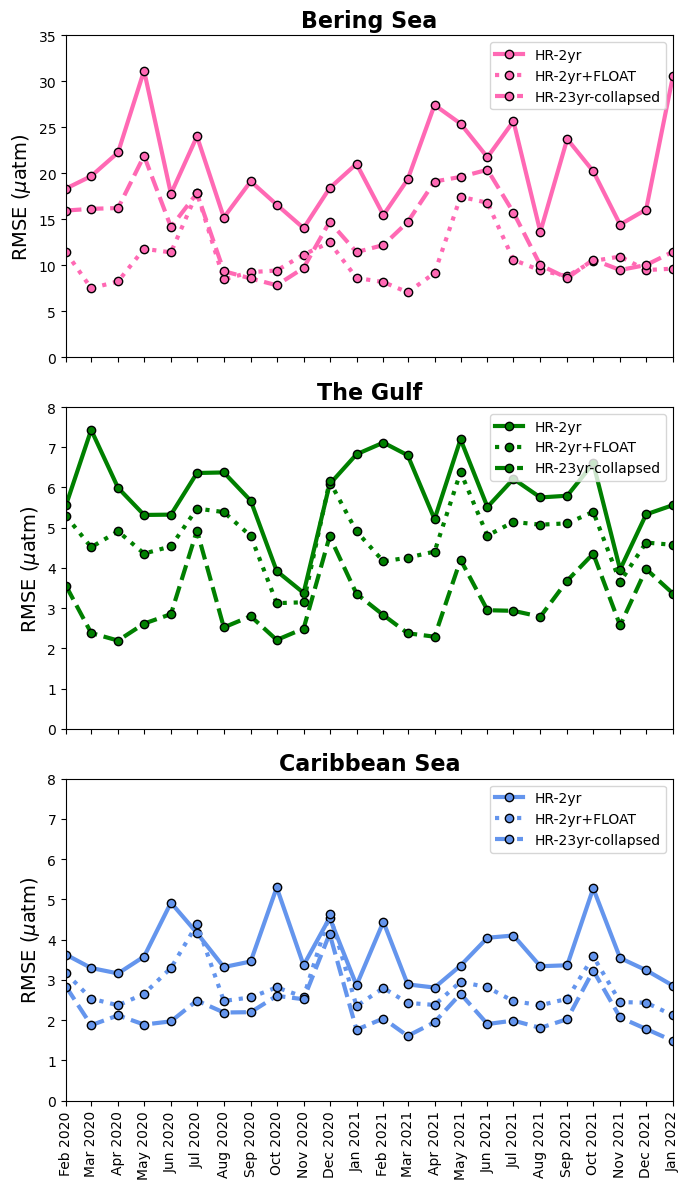

In [17]:
import matplotlib.dates as mdates
fig, axes = plt.subplots(3, 1, figsize=(7, 12), sharex=True)

# Define time limits
start_time = np.datetime64('2020-02')
end_time = rmse_caribbean_for_timeseries_global_2000_2022.time[-1].values  # exact endpoint

for ax in axes:
    ax.set_xlim(start_time, end_time)

# --- Panel 1: Bering Sea ---
ax = axes[0]
ax.set_title('Bering Sea', fontsize=16, fontweight = 'bold')
ax.plot(rmse_bering_for_timeseries_global_2020_2022.time,
        rmse_bering_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='hotpink', label='HR-2yr', linestyle='solid',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(rmse_bering_for_timeseries_global_2020_2022_float.time,
        rmse_bering_for_timeseries_global_2020_2022_float.mean(['longitude', 'latitude']),
        linewidth=3.0, c='hotpink', label='HR-2yr+FLOAT', linestyle='dotted',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(rmse_bering_for_timeseries_global_2000_2022.time,
        rmse_bering_for_timeseries_global_2000_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='hotpink', label='HR-23yr-collapsed', linestyle='dashed',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
#ax.axhline(0, zorder=-10, c='black')
#ax.fill_between(bias_bering_for_timeseries_global_2000_2022.time, -2, 2, color='grey', alpha=0.3)
ax.set_ylabel('RMSE ($\mu$atm)', fontsize=14)
ax.legend(loc='upper right')
ax.set_ylim(0, 35)

# --- Panel 2: Gulf ---
ax = axes[1]
ax.set_title('The Gulf', fontsize=16, fontweight = 'bold')
ax.plot(rmse_gulf_for_timeseries_global_2020_2022.time,
        rmse_gulf_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='green', label='HR-2yr', linestyle='solid',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(rmse_gulf_for_timeseries_global_2020_2022_float.time,
        rmse_gulf_for_timeseries_global_2020_2022_float.mean(['longitude', 'latitude']),
        linewidth=3.0, c='green', label='HR-2yr+FLOAT', linestyle='dotted',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(rmse_gulf_for_timeseries_global_2000_2022.time,
        rmse_gulf_for_timeseries_global_2000_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='green', label='HR-23yr-collapsed', linestyle='dashed',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
#ax.axhline(0, zorder=-10, c='black')
#ax.fill_between(bias_gulf_for_timeseries_global_2000_2022.time, -2, 2, color='grey', alpha=0.3)
ax.set_ylabel('RMSE ($\mu$atm)', fontsize=14)
ax.legend(loc='upper right')
ax.set_ylim(0, 8)

# --- Panel 3: Caribbean Sea ---
ax = axes[2]
ax.set_title('Caribbean Sea', fontsize=16, fontweight = 'bold')
ax.plot(rmse_caribbean_for_timeseries_global_2020_2022.time,
        rmse_caribbean_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='cornflowerblue', label='HR-2yr', linestyle='solid',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(rmse_caribbean_for_timeseries_global_2020_2022_float.time,
        rmse_caribbean_for_timeseries_global_2020_2022_float.mean(['longitude', 'latitude']),
        linewidth=3.0, c='cornflowerblue', label='HR-2yr+FLOAT', linestyle='dotted',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(rmse_caribbean_for_timeseries_global_2000_2022.time,
        rmse_caribbean_for_timeseries_global_2000_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='cornflowerblue', label='HR-23yr-collapsed', linestyle='dashed',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
#ax.axhline(0, zorder=-10, c='black')
#ax.fill_between(bias_caribbean_for_timeseries_global_2000_2022.time, -2, 2, color='grey', alpha=0.3)
ax.set_ylabel('RMSE ($\mu$atm)', fontsize=14)
ax.legend(loc='upper right')
ax.set_ylim(0, 8)

# Format x-axis only on the bottom plot
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# plt.setp(ax.get_xticklabels(), rotation=90)

# Format x-axis only on the bottom plot
axes[2].xaxis.set_major_locator(mdates.MonthLocator())
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(axes[2].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.savefig("/home/jovyan/timeseries_RMSE_comparison.jpg", dpi=300, bbox_inches="tight")